In [2]:
# Imports
from langchain_openai import ChatOpenAI







In [25]:
from getpass import getpass
import os


def _set_if_undefined(var: str):
    if not os.environ.get(var):
        print(f"Please provide your {var}")
        os.environ[var] = getpass(f"Please provide your {var}")


_set_if_undefined("OPENAI_API_KEY")
_set_if_undefined("LANGCHAIN_API_KEY")
_set_if_undefined("TAVILY_API_KEY")

In [26]:
# Optional, add tracing in LangSmith
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "Multi-agent Teaching Coder 1"

# Main Graph notebook
### This project consists of several sub-systems, ie. sub-graphs, that are all linked together in this notebook.



In [ ]:
# Define LLM to be used for all agents

# llm = ChatOpenAI(model="gpt-4-1106-preview") # TOO EXPENSIVE FOR TESTING
llm = ChatOpenAI(model="gpt-3.5-turbo-0125")

## Initiate subgraphs, and then collect them in the main graph

In [ ]:
from thesis2024.models.coding_agent import CodingMultiAgent
coding_node = CodingMultiAgent(llm=llm)

In [ ]:
from thesis2024.models.teaching_agent import TeachingMultiAgent
teaching_node = TeachingMultiAgent(llm=llm)

In [ ]:
from thesis2024.models.digital_twin_agent import DigitalTwinAgent
digital_twin_node = DigitalTwinAgent(llm=llm)

In [ ]:
import operator
from typing import Annotated, Sequence, TypedDict
from langchain_core.messages import (AIMessage, BaseMessage, ChatMessage, FunctionMessage, HumanMessage,)
from langgraph.graph import END, StateGraph
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]
    sender: str


workflow = StateGraph(AgentState)

workflow.add_node("Coder", coding_node)
workflow.add_node("Chart Generator", chart_node)
workflow.add_node("call_tool", tool_node)

workflow.add_conditional_edges(
    "Researcher",
    router,
    {"continue": "Chart Generator", "call_tool": "call_tool", "end": END},
)
workflow.add_conditional_edges(
    "Chart Generator",
    router,
    {"continue": "Researcher", "call_tool": "call_tool", "end": END},
)

workflow.add_conditional_edges(
    "call_tool",
    # Each agent node updates the 'sender' field
    # the tool calling node does not, meaning
    # this edge will route back to the original agent
    # who invoked the tool
    lambda x: x["sender"],
    {
        "Researcher": "Researcher",
        "Chart Generator": "Chart Generator",
    },
)
workflow.set_entry_point("Researcher")
graph = workflow.compile()

## Create Agents

The following helper functions will help create agents. These agents will then be nodes in the graph.

In [28]:


def digital_twin_agent(llm, tools, system_message: str):
    """Create an agent."""
    functions = [format_tool_to_openai_function(t) for t in tools]

    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                "You are a digital twin assistant."
                " You're job is to read through conversation memory, "
                " and update a summary of what the user knows and does not know. "
                " Other assistants will use this summary best umnderstand what the user needs help for. "
                " You have access to the following tools: {tool_names}.\n{system_message}",
            ),
            MessagesPlaceholder(variable_name="messages"),
        ]
    )
    prompt = prompt.partial(system_message=system_message)
    prompt = prompt.partial(tool_names=", ".join([tool.name for tool in tools]))
    return prompt | llm.bind_functions(functions)


def teaching_minded_agent(llm, tools, system_message: str):
    """Create an agent."""
    functions = [format_tool_to_openai_function(t) for t in tools]

    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                "You are a helpful assitant with the goal of helping a student learn as much as possible."
                " Your goal is to best determine how to  "
                " You have access to the following tools: {tool_names}.\n{system_message}",
            ),
            MessagesPlaceholder(variable_name="messages"),
        ]
    )
    prompt = prompt.partial(system_message=system_message)
    prompt = prompt.partial(tool_names=", ".join([tool.name for tool in tools]))
    return prompt | llm.bind_functions(functions)

{'Researcher': {'messages': [HumanMessage(content='', additional_kwargs={'function_call': {'arguments': '{"query":"largest 10 mountains in the world"}', 'name': 'tavily_search_results_json'}}, name='Researcher')], 'sender': 'Researcher'}}
----
{'call_tool': {'messages': [FunctionMessage(content='tavily_search_results_json response: [{\'url\': \'https://en.wikipedia.org/wiki/List_of_highest_mountains_on_Earth\', \'content\': "88 | 4\\n87 |\\n86 | 1\\n85 | 8 1\\n84 | 8\\n83 |\\n82 |\\n81 | 8 6 6 2\\n80 | 9 8 5 3 2\\n79 | 5 4 3 3\\n78 | 9 8 7 6 2 2 1 0\\n77 | 9 9 8 8 5 5 4 1 0 0\\n76 |\\n9 7 6 6 4 1 1\\n75 | 7 7 5 5 4 4 4 3 3 1 1\\n74 | 9 9 9 9 7 6 6 6 5 5 3 3 2 2 2 1 1 1 0 0 0\\n73 | 8 8 8 8 8 6 6 5 5 5 4 2 1 1 1 0\\n72 | 9 9 9 8 8 8 8 7 7 6 6 5 4 4 4 3 2 2 1 1 0 0 0 0 0 0 0\\nGallery[edit]\\n1. All peaks 7,000\\xa0m (23,000\\xa0ft) or higher are located in East, Central or South Asia in a rectangle edged by Noshaq (7,492\\xa0m or 24,580\\xa0ft) on the Afghanistan–Pakistan border in the 

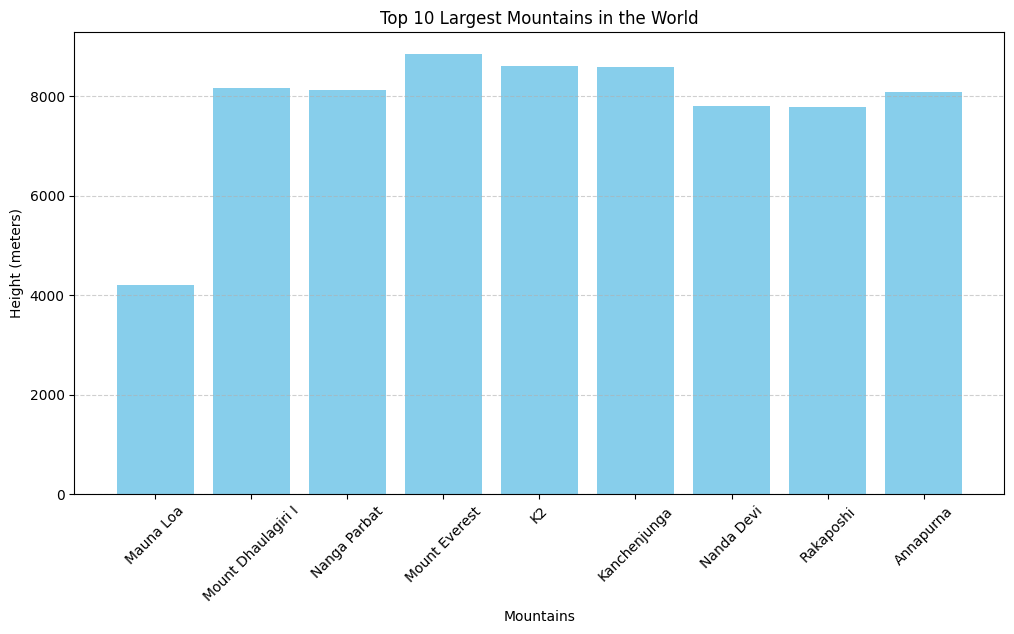

{'Chart Generator': {'messages': [HumanMessage(content="To visualize the heights of the largest 10 mountains in the world, I can create a bar graph showing the heights of these mountains. Let's create the graph with the available data.", additional_kwargs={'function_call': {'arguments': '{"code":"import matplotlib.pyplot as plt\\n\\n# Mountain data\\nmountains = [\'Mauna Loa\', \'Mount Dhaulagiri I\', \'Nanga Parbat\', \'Mount Everest\', \'K2\', \'Kanchenjunga\', \'Nanda Devi\', \'Rakaposhi\', \'Annapurna\']\\nheights = [4209, 8167, 8126, 8848, 8611, 8586, 7816, 7788, 8091]\\n\\n# Create a bar graph\\nplt.figure(figsize=(12, 6))\\nplt.bar(mountains, heights, color=\'skyblue\')\\nplt.xlabel(\'Mountains\')\\nplt.ylabel(\'Height (meters)\')\\nplt.title(\'Top 10 Largest Mountains in the World\')\\nplt.xticks(rotation=45)\\nplt.grid(axis=\'y\', linestyle=\'--\', alpha=0.6)\\n\\nplt.show()"}', 'name': 'python_repl'}}, name='Chart Generator')], 'sender': 'Chart Generator'}}
----
{'call_tool':

In [35]:
for s in graph.stream(
    {
        "messages": [
            HumanMessage(
                content="Make a graph over the largest 10 mountains in the world."
            )
        ],
    },
    # Maximum number of steps to take in the graph
    {"recursion_limit": 100},
):
    print(s)
    print("----")